In [3]:
import math
import json
import random
import itertools
from os import path
import pandas as pd
import numpy as np
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import AlignIO
from Bio.Align import MultipleSeqAlignment
from Bio.Align import AlignInfo
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
from scipy import stats


Bad key "text.kerning_factor" on line 4 in
/Users/katekistler/anaconda3/envs/nextstrain/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [4]:
def separate_clades(cov, gene):
    if cov == 'hku1':
        clade_file = '../'+str(cov)+'/results/clades_full.json'
    else:
        if path.exists('../'+str(cov)+'/results/clades_'+str(gene)+'.json'):
            clade_file = '../'+str(cov)+'/results/clades_'+str(gene)+'.json'
#         if gene =='spike' or gene == 's1' or gene == 's2':
#             clade_file = '../'+str(cov)+'/results/clades_spike.json'
        else:
            clade_file = '../'+str(cov)+'/results/clades_full.json'
    
    clade_lists = []
    with open(clade_file, "r") as clade_handle:
        clades = json.load(clade_handle)
        for node, v in clades['nodes'].items():
            if 'NODE' not in node:
                clade_lists.append({'clade':v['clade_membership'],
                                   'strain':node})

    clade_df = pd.DataFrame(clade_lists)
    return clade_df

In [5]:
def subset_viruses(cov, gene, window, clade, min_seqs, year_max=None, year_min= None):
#     input_file_outgroup = '../'+str(cov)+'/auspice/seasonal_corona_'+str(cov)+'_'+str(gene)+'_root-sequence.json'
    input_file_alignment = '../'+str(cov)+'/results/aligned_'+str(cov)+'_'+str(gene)+'.fasta'
    metafile = '../'+str(cov)+'/results/metadata_'+str(cov)+'_'+str(gene)+'.tsv'
    
    #Subset data based on time windows
    meta = pd.read_csv(metafile, sep = '\t')
    meta.drop(meta[meta['date']=='?'].index, inplace=True)
    meta.dropna(subset=['date'], inplace=True)
    meta['year'] = meta['date'].str[:4].astype('int')
    if year_max:
        meta.drop(meta[meta['year']>year_max].index, inplace=True)
    if year_min:
        meta.drop(meta[meta['year']<year_min].index, inplace=True)
    
    date_range = meta['year'].max() - meta['year'].min()
    
    
    if clade!= None:
        clade_df = separate_clades(cov, gene)
        meta = meta.merge(clade_df, on='strain')
        meta.drop(meta[meta['clade']!=clade].index, inplace=True)
    
    
    #Group viruses by time windows
    virus_time_subset = {}
    if window == 'all':
        years = str(meta['year'].min()) + '-' + str(meta['year'].max())
        virus_time_subset[years] = meta['strain'].tolist()
    else:
        date_window_start = meta['year'].min()
        date_window_end = meta['year'].min() + window
        while date_window_end <= meta['year'].max():
            years = str(date_window_start) + '-' + str(date_window_end)
            strains = meta[(meta['year']>=date_window_start) & (meta['year']<date_window_end)]['strain'].tolist()
            virus_time_subset[years] = strains
            
            #non-overlapping
#             date_window_end += window
#             date_window_start+= window
            
            #sliding window
            date_window_end += 1
            date_window_start += 1 
    
    #Only use time points with enough data:
    virus_time_subset = {k:v for k,v in virus_time_subset.items() if len(v)>=min_seqs}


    year_windows = []
    seqs_in_window = []
    
    #Find outgroup sequence from strains at first time point(to make consensus from)
    first_window = True
    first_window_strains = []
    first_window_sequences = []
    
    alignment_time_subset = {}
    
    
    for years, subset_viruses in virus_time_subset.items():
        year_windows.append(years)
        seqs_in_window.append(len(subset_viruses))
        alignment_time_subset[years] = []

        #make consensus sequence at first time point
        if first_window == True:
            first_window_strains+=subset_viruses
            first_window = False

        with open(input_file_alignment, "r") as aligned_handle:
            for virus in SeqIO.parse(aligned_handle, "fasta"):
                if virus.id in first_window_strains:
                    first_window_sequences.append(virus)
                if virus.id in subset_viruses:
                    alignment_time_subset[years].append(virus.seq)


    first_window_alignment = MultipleSeqAlignment(first_window_sequences)
    outgroup_seq = AlignInfo.SummaryInfo(first_window_alignment).dumb_consensus(ambiguous ='N')
    outgroup_aa_seq = outgroup_seq.translate()
    gene_length = len(outgroup_seq)

    
    return virus_time_subset, alignment_time_subset, gene_length, year_windows, seqs_in_window 
    

In [6]:
test_seq1 = Seq('ATGGATTCGTAGCTGATGGACCCATGTTTAGTTTACACTGCTANNNNNNGGTCCCAATTT')
test_seq2 = Seq('ATGCATTCGTAGCTGATGGAGCCATGATTAGTTTACACTGCTANNNNNNGCTACCGACTT')
test_seq3 = Seq('ATGCATACGTAGCTGATCCTGCCATGATTACTATACACTGCTANNNAATGCTACCGACTT')
test_seq4 = Seq('ATGCATCCGAAGGTGATCGAGCCATCATCAGTTTACACTGCTANNNAATGGTACCGACTT')
test_alignment = [test_seq1, test_seq2, test_seq3, test_seq4]

In [7]:
def calculate_pairwise_diversity(seq1, seq2):
    
    #look in sliding windows of 100nt
    gene_len = len(seq1)
    nt_window_size = 100
    start_pos = 0
    window_increment = 30
    
    window_pairwise_diversity = []
    window_start_pos = []
    
    for x in range(gene_len):
        seq1_window_nt = seq1[start_pos:start_pos+nt_window_size]
        seq2_window_nt = seq2[start_pos:start_pos+nt_window_size]

        #Only look at full-length windows. Windows at the end of the sequence will be truncated
        if len(seq1_window_nt) == nt_window_size:
        
            total_sites = nt_window_size
            diversity_count = 0
            for pos in range(len(seq1_window_nt)):
                if seq1_window_nt[pos] != 'N' and seq2_window_nt[pos] != 'N':
                    if seq1_window_nt[pos] != seq2_window_nt[pos]:
                        diversity_count +=1
                else:
                    total_sites-=1
     
            #if strains are not sequenced at these positions, do not include them in diversity count
            if total_sites == 0:
                diversity_ratio = np.nan
            elif total_sites != 0:
                diversity_ratio = diversity_count/total_sites
            

            #keep track of pairwise diversity for each nucleotide window
            window_pairwise_diversity.append(diversity_ratio)
            window_start_pos.append(start_pos)

            start_pos+=window_increment
        
    return window_pairwise_diversity, window_start_pos

In [8]:
def calc_average_pairwise_diversity(alignment_seqs):
    
    #Store all pairwise comparisons
    all_pairwise_diversity = []

    #Pairwise comparison for every pair of sequences in time window           
    for pair in itertools.combinations(alignment_seqs, 2):
        window_pairwise_diversity, window_start_pos = calculate_pairwise_diversity(*pair)
        all_pairwise_diversity.append(window_pairwise_diversity)

    #Find average pairwise diversity at each position
    avg_pairwise_diversity = [np.nanmean(pos) for pos in zip(*all_pairwise_diversity)]
    
    return avg_pairwise_diversity, window_start_pos

In [9]:
def calc_pairwise_diversity_per_window(alignment_sequences):

    #initiate lists to record all time windows
    pairwise_diversity_per_window = []


    for years, alignment_seqs in alignment_sequences.items():
  
        #calculate diversity for each window
        avg_pairwise_diversity, window_start_pos = calc_average_pairwise_diversity(alignment_seqs)
        pairwise_diversity_per_window.append(avg_pairwise_diversity)
            
    return pairwise_diversity_per_window, window_start_pos
            


In [11]:
def plot_pairwise_diversity_per_pos(cov, gene, window, clade, min_seqs=3, filename=None):
    
    virus_time_subset, alignment_time_subset, gene_length, year_windows, seqs_in_window = subset_viruses(cov, gene, window, clade, min_seqs)

    pairwise_diversity_per_window, window_start_pos = calc_pairwise_diversity_per_window(alignment_time_subset)
    
    to_plot = []
    for year_window in range(len(pairwise_diversity_per_window)):
        for pos_window in range(len(pairwise_diversity_per_window[year_window])):
            to_plot.append({'year': year_windows[year_window], 
                            'avg_diversity':pairwise_diversity_per_window[year_window][pos_window], 
                            'pos': window_start_pos[pos_window]})
    df_to_plot = pd.DataFrame(to_plot)
    
    fig, ax = plt.subplots(figsize=(15,8))
    
    ax= sns.lineplot(x='pos', y='avg_diversity', hue='year', data=df_to_plot)
    
    plt.ylabel('average pairwise diversity')
    
    if filename:
        fig.savefig(filename)
    

In [34]:
def plot_avg_pairwise_diversity_per_pos(cov, gene, window, clade, min_seqs=3, filename=None):
    
    virus_time_subset, alignment_time_subset, gene_length, year_windows, seqs_in_window = subset_viruses(cov, gene, window, clade, min_seqs)

    pairwise_diversity_per_window, window_start_pos = calc_pairwise_diversity_per_window(alignment_time_subset)
    
    
    avg_pairwise_diversity_by_site = [np.nanmean(pos) for pos in zip(*pairwise_diversity_per_window)]

    to_plot = []
    for pos_window in range(len(avg_pairwise_diversity_by_site)):
        to_plot.append({'avg_diversity':avg_pairwise_diversity_by_site[pos_window], 
                        'pos': window_start_pos[pos_window]})
    df_to_plot = pd.DataFrame(to_plot)
    
    fig, ax = plt.subplots(figsize=(15,8))
    
    ax= sns.lineplot(x='pos', y='avg_diversity', data=df_to_plot)
    
    plt.ylabel('average pairwise diversity')
    
    if filename:
        fig.savefig(filename)
    

/Users/katekistler/anaconda3/envs/nextstrain/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':


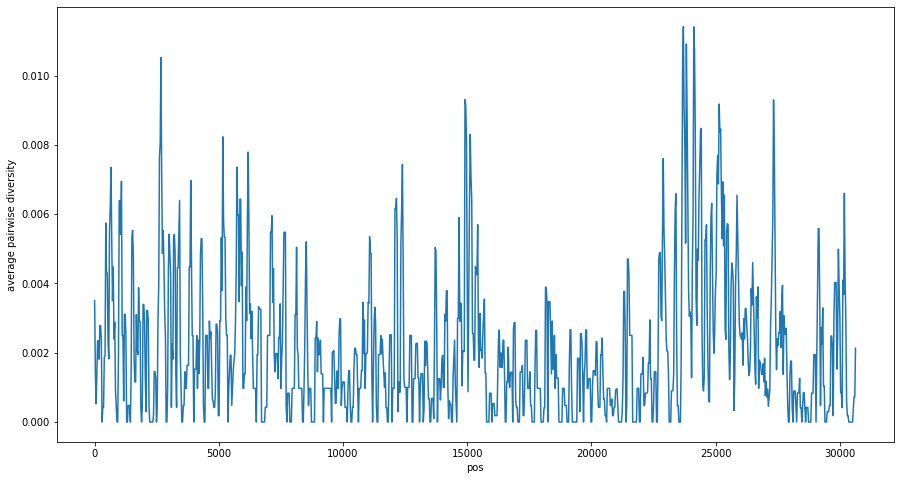

In [35]:
plot_avg_pairwise_diversity_per_pos('oc43', 'full', 3, 'A')

/Users/katekistler/anaconda3/envs/nextstrain/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':


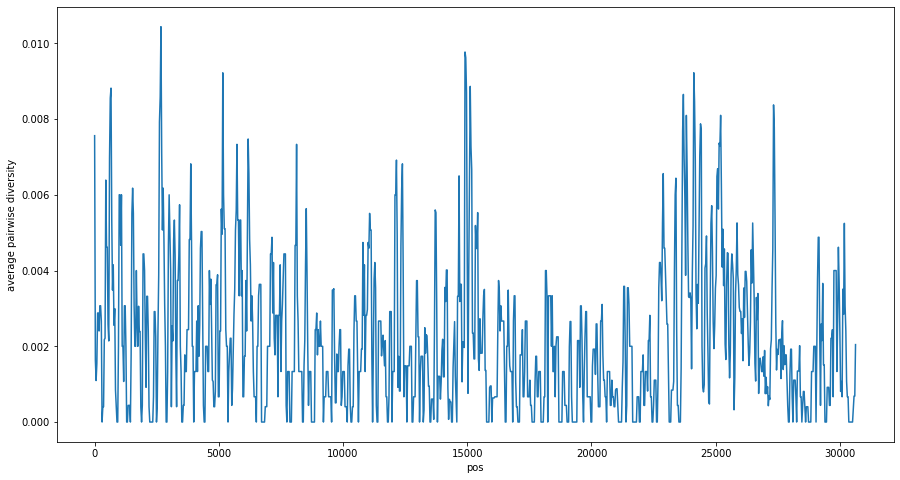

In [36]:
plot_avg_pairwise_diversity_per_pos('oc43', 'full', 2, 'A', filename='oc43a_pairwise_diversity_2yrwindow.png')

In [ ]:
plot_avg_pairwise_diversity_per_pos('oc43', 'full', 5, 'A', filename='oc43a_pairwise_diversity_5yrwindow.png')

/Users/katekistler/anaconda3/envs/nextstrain/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':


/Users/katekistler/anaconda3/envs/nextstrain/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':


        year  avg_diversity  pos
0  1990-1993            0.0    0
1  1990-1993            0.0    2
2  1990-1993            0.0    4
3  1990-1993            0.0    6
4  1990-1993            0.0    8


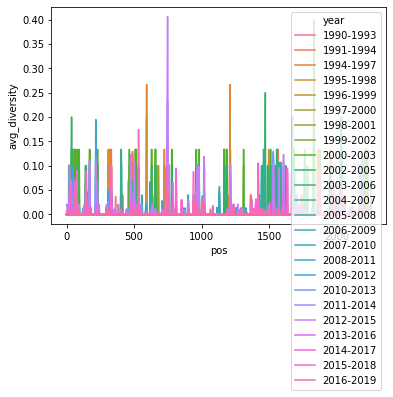

In [214]:
plot_pairwise_diversity_per_pos('oc43', 's1', 3, 'A')

/Users/katekistler/anaconda3/envs/nextstrain/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':


        year  avg_diversity  pos
0  1989-1992            0.0    0
1  1989-1992            0.0    2
2  1989-1992            0.0    4
3  1989-1992            0.0    6
4  1989-1992            0.0    8


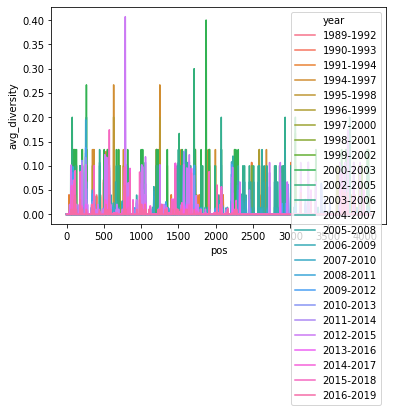

In [215]:
plot_pairwise_diversity_per_pos('oc43', 'spike', 3, 'A')

        year  avg_diversity  pos
0  1967-2019            0.0    0
1  1967-2019            0.0    2
2  1967-2019            0.0    4
3  1967-2019            0.0    6
4  1967-2019            0.0    8


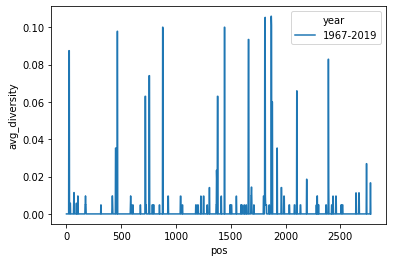

In [216]:
plot_pairwise_diversity_per_pos('oc43', 'rdrp', 'all', 'A')

/Users/katekistler/anaconda3/envs/nextstrain/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':


        year  avg_diversity  pos
0  1967-2019            0.0    0
1  1967-2019            0.0    2
2  1967-2019            0.0    4
3  1967-2019            0.0    6
4  1967-2019            0.0    8


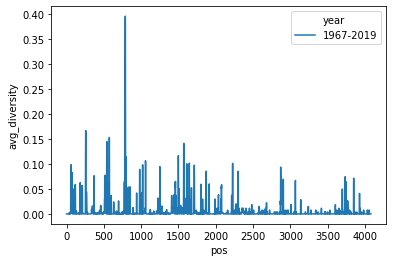

In [212]:
plot_pairwise_diversity_per_pos('oc43', 'spike', 'all', 'A')

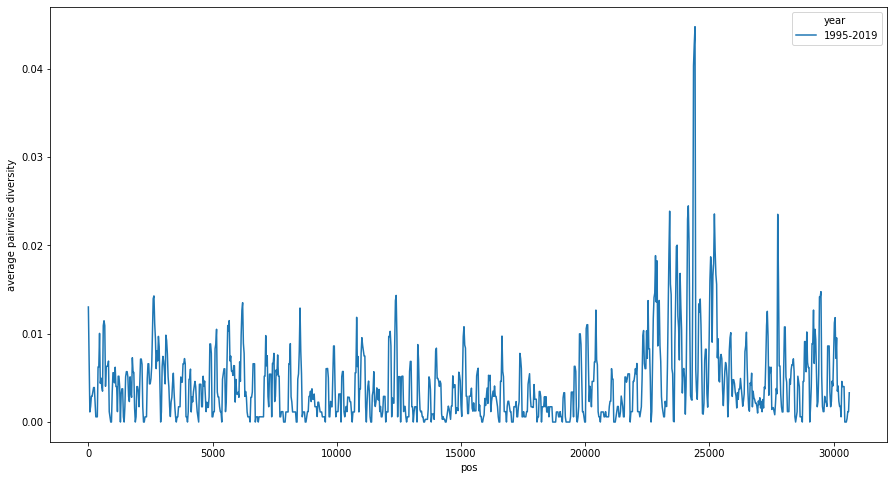

In [12]:
plot_pairwise_diversity_per_pos('oc43', 'full', 'all', 'A', filename='oc43a_pairwise_diversity.png')

In [ ]:
virus_time_subset, alignment_time_subset, gene_length, year_windows, seqs_in_window = subset_viruses('oc43', 'spike', 'all', 'A', 3)

pairwise_diversity_per_window, window_start_pos = calc_pairwise_diversity_per_window(alignment_time_subset)

print(len(pairwise_diversity_per_window))
print(pairwise_diversity_per_window)
print(len(window_start_pos))
print(window_start_pos)
print(len(year_windows))
print(year_windows)